In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf 
tf.compat.v1.disable_eager_execution()
import scipy.io as scio 
import scipy.io as sio
import scipy  
from tensorflow.python.framework import ops  
from matplotlib.colors import ListedColormap   
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report 

In [3]:
def split_data(Labeled_points, Labels, test_size=0.3, random_state=42):
     

    # Set the random seed, if provided
    if random_state is not None:
        np.random.seed(random_state)

    # Get the number of data points
    num_points = Labeled_points.shape[0]

    # Calculate the number of points to use for testing
    num_test = int(num_points * test_size)

    # Shuffle the indices of the data points
    indices = np.random.permutation(num_points)

    # Split the indices into training and testing sets
    test_indices = indices[:num_test]
    train_indices = indices[num_test:]

    # Use the indices to get the training and testing data points and labels
    X_train = Labeled_points[train_indices]
    X_test = Labeled_points[test_indices]
    y_train = Labels[train_indices]
    y_test = Labels[test_indices]

    return X_train, X_test, y_train, y_test

In [4]:
def random_mini_batches_single(x_train_set, y_train_set, minibatch_size, seed=0):
    m = x_train_set.shape[0]  # number of training examples
    np.random.seed(seed)
    # Shuffle the data
    permutation = list(np.random.permutation(m))
    shuffled_x = x_train_set[permutation, :]
    shuffled_y = y_train_set[permutation, :]

    # Partition (shuffled_x, shuffled_y). Minus the end case.
    # number of mini batches of size mini_batch_size in your partitionning
    num_complete_minibatches = m // minibatch_size
    minibatches = []
    for k in range(0, num_complete_minibatches):
        minibatch_x = shuffled_x[k * minibatch_size: k *
                                 minibatch_size + minibatch_size, :]
        minibatch_y = shuffled_y[k * minibatch_size: k *
                                 minibatch_size + minibatch_size, :]
        minibatch = (minibatch_x, minibatch_y)
        minibatches.append(minibatch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % minibatch_size != 0:
        minibatch_x = shuffled_x[num_complete_minibatches *
                                 minibatch_size: m, :]
        minibatch_y = shuffled_y[num_complete_minibatches *
                                 minibatch_size: m, :]
        minibatch = (minibatch_x, minibatch_y)
        minibatches.append(minibatch)
    return minibatches

In [5]:
def create_placeholders(n_x, n_y):
    
    x = tf.compat.v1.placeholder(tf.float32, [None, n_x], name = "x")   #Tensor("x:0", shape=(?, 200), dtype=float32)
    y = tf.compat.v1.placeholder(tf.float32, [None, n_y], name = "Y")   #Tensor("Y:0", shape=(?, 16), dtype=float32)
    isTraining = tf.compat.v1.placeholder_with_default(True, shape=())  #Tensor("PlaceholderWithDefault:0", shape=(), dtype=bool)   
    return x, y, isTraining


In [6]:
def initialize_parameters():

    
    tf.compat.v1.set_random_seed(1)
     
    x_w1 = tf.compat.v1.get_variable("x_w1", [1,1,224,118], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_b1 = tf.compat.v1.get_variable("x_b1", [118], initializer = tf.compat.v1.zeros_initializer())
    
    x_w2 = tf.compat.v1.get_variable("x_w2", [1,1,118,12], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_b2 = tf.compat.v1.get_variable("x_b2", [12], initializer = tf.compat.v1.zeros_initializer())
    
    
#     x_w1 shape : (1, 1, 200, 128)                                   #doubt
#     x_b1 shape : (128,)
#     x_w2 shape  : (1, 1, 128, 16)
#     x_b2 : (16,)
    
    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_w2": x_w2,
                  "x_b2": x_b2}

    return parameters

In [7]:
def mynetwork(x, parameters, isTraining, momentums = 0.9): 
    x = tf.reshape(x, [-1, 1, 1, 224], name = "x")   
    with tf.compat.v1.name_scope("x_layer_1"):                                    
         
         x_z1 = tf.nn.conv2d(x, filters=parameters['x_w1'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_b1']  
         x_z1_bn = tf.compat.v1.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)   
         x_a1 = tf.nn.relu(x_z1_bn)
         
    with tf.compat.v1.name_scope("x_layer_3"):
        
         x_z2 = tf.nn.conv2d(x_a1, filters=parameters['x_w2'], strides=[1, 1, 1, 1], padding='SAME') + parameters['x_b2'] 
         x_z2_shape = x_z2.get_shape().as_list() 
         x_z2_2d = tf.reshape(x_z2, [-1, x_z2_shape[1] * x_z2_shape[2] * x_z2_shape[3]])   
                    
         
    l2_loss =   tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_w2'])
               
    return x_z2_2d, l2_loss


In [8]:
def mynetwork_optimaization(y_es, y_re, l2_loss, reg, learning_rate, global_step):
    
    with tf.compat.v1.name_scope("cost"):
        
         cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = y_es, labels = tf.stop_gradient( y_re))) + reg * l2_loss
               
    with tf.compat.v1.name_scope("optimization"):
         update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost, global_step=global_step)
         optimizer = tf.group([optimizer, update_ops])
                   
    return cost, optimizer

In [9]:
def train_mynetwork(x_train_set, y_train_set, x_test_set, y_test_set, Cuprite_data, learning_rate_base = 0.001, beta_reg = 0.001, num_epochs = 200, minibatch_size = 32, print_cost = True):
    
    ops.reset_default_graph()                       
    tf.compat.v1.set_random_seed(1)                          
    seed = 1                                    
    (m, n_x) = x_train_set.shape  # m: 695  n_x shape : 200                  
    (m, n_y) = y_train_set.shape  #n_y shape : 16    
     

    costs = []                                   
    costs_dev = []
    train_acc = []
    val_acc = []
    correct_prediction = 0
    
    # Create Placeholders of shape (n_x, n_y)
    x, y, isTraining = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    with tf.compat.v1.name_scope("network"):
         x_out, l2_loss= mynetwork(x, parameters, isTraining)                    #doubt
         
    global_step = tf.Variable(0, trainable = False)                             # 50 * m/minibatch_size
    learning_rate = tf.compat.v1.train.exponential_decay(learning_rate_base, global_step, 50 * m/minibatch_size, 0.5, staircase = True)
    
    with tf.compat.v1.name_scope("optimization"):
         # network optimization
         cost, optimizer = mynetwork_optimaization(x_out, y, l2_loss, beta_reg, learning_rate, global_step)

    with tf.compat.v1.name_scope("metrics"):
         # Calculate the correct predictions
         joint_layerT = tf.transpose(x_out)
         yT = tf.transpose(y)
         correct_prediction = tf.equal(tf.argmax(joint_layerT), tf.argmax(yT))
         accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
         
    

    # Initialize all the variables
    init = tf.compat.v1.global_variables_initializer()     


    # Start the session to compute  
    with tf.compat.v1.Session() as sess:
        
        # Run the initialization
        sess.run(init) 
        # Do the training loop
        for epoch in range(num_epochs + 1):
            
            epoch_cost = 0.                       # Defines a cost related to an epoch
            epoch_acc = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches_single(x_train_set, y_train_set, minibatch_size, seed)
            for minibatch in minibatches:

                # Select a minibatch
                (batch_x, batch_y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _, minibatch_cost, minibatch_acc = sess.run([optimizer, cost, accuracy], feed_dict={x: batch_x, y: batch_y, isTraining: True})
           
                epoch_cost += minibatch_cost / (num_minibatches+ 1)
                epoch_acc += minibatch_acc / (num_minibatches + 1)
 
            features, epoch_cost_dev, epoch_acc_dev = sess.run([x_out, cost, accuracy], feed_dict={x: x_test_set, y: y_test_set, isTraining: False})
            costs.append(epoch_cost)
            train_acc.append(epoch_acc)
            costs_dev.append(epoch_cost_dev)
            val_acc.append(epoch_acc_dev)
                                    
        print("Training")
        for i in range(5):
            print(f"epoch {i*50}: Train_loss: {costs[i*50]}, Train_acc: {train_acc[i*50]}") 
        print("Validating")
        for j in range(5):
            print(f"epoch {j*50}: Validating_loss: {costs_dev[j*50]}, Validating_acc: {val_acc[j*50]}") 
             

        Cuprite_out = sess.run([x_out], feed_dict={x:Cuprite_data, isTraining:False})  
        Cuprite_out = Cuprite_out[0] 
        num_labels = 12
        labels = np.argmax(Cuprite_out, axis=1)
        labels = labels.reshape(-1, 1) 


        cuprite_3d = np.reshape(Cuprite_data, (512, 614, 224))

        # Reshape label array to 2D array
        label_2d = np.reshape(labels, (512, 614))

        # Define color map for elements
        colors = ['#8B0000', '#FFA500', '#FFFF00', '#00CED1', '#228B22', '#008000', '#808080', '#FFC0CB', '#800080', '#FF69B4', '#0000FF', '#a52a2a']
        # colors = ['#660000', '#CC6600', '#CCCC00', '#006666', '#004400', '#003300', '#555555', '#FF99CC', '#660066', '#FF3399', '#000066', '#660000']
        cmap = ListedColormap(colors)

        # Define color for unlabeled pixels
        cmap.set_under('white')

        # Plot the image with labels
        fig, ax = plt.subplots()
        im = ax.imshow(label_2d, cmap=cmap, vmin=0.5, vmax=12.5, interpolation='nearest')
        cbar = fig.colorbar(im, ax=ax, ticks=range(1, 13))
        cbar.ax.set_yticklabels(["#1 Alunite", "#2 Andradite", "#3 Buddingtonite", "#4 Dumortierite", "#5 Kaolinite1", 
                                 "#6 Kaolinite2", "#7 Muscovite", "#8 Montmorillonite", "#9 Nontronite", "#10 Pyrope",
                                 "#11 Sphene", "#12 Chalcedony"])
        cbar.ax.tick_params(labelsize=8)
        cbar.ax.set_ylabel('Mineral Labels', fontsize=10)
        plt.show()


                 
        # plot the cost      
        plt.plot(np.squeeze(costs), label='Training cost')
        plt.plot(np.squeeze(costs_dev), label='Validation cost')
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.legend()
        plt.show()
        # plot the accuracy 
        plt.plot(np.squeeze(train_acc), label='Training accuracy')
        plt.plot(np.squeeze(val_acc), label='Validation accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.legend()
        plt.show()
         
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
       
        return parameters, val_acc, features


(736, 224)
(315, 224)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Training
epoch 0: Train_loss: 2.1635702451070147, Train_acc: 0.30859375
epoch 50: Train_loss: 0.4143025428056717, Train_acc: 0.8372395833333333
epoch 100: Train_loss: 0.30235151263574755, Train_acc: 0.8893229166666666
epoch 150: Train_loss: 0.25776292321582633, Train_acc: 0.9140625
epoch 200: Train_loss: 0.27083606024583184, Train_acc: 0.90625
Validating
epoch 0: Validating_loss: 2.3418571949005127, Validating_acc: 0.27936509251594543
epoch 50: Validating_loss: 0.6531844139099121, Validating_acc: 0.7873015999794006
epoch 100: Validating_loss: 0.502880871295929, Validating_acc: 0.8444444537162781

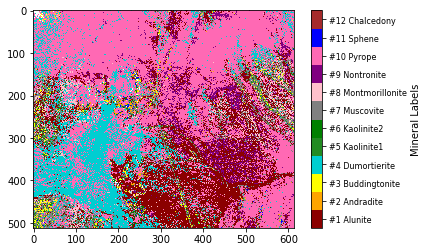

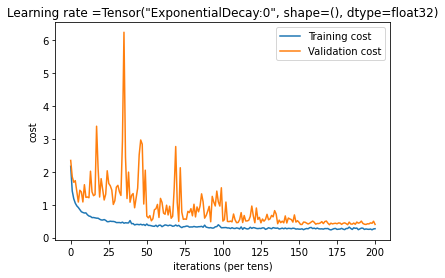

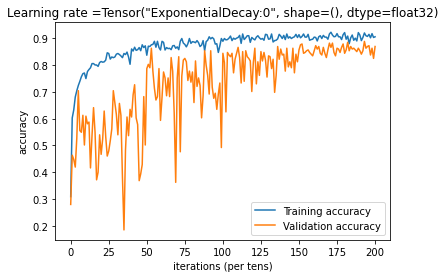

Parameters have been trained!
(315,) (315,)
Confusion Matrix:
 [[16  0  0  0  0  1  0  0  1  0  0  0]
 [ 0 21  0  0  0  0  0  1  0  2  0  0]
 [ 0  0  8  0  0  0  2  0  0  0  0  0]
 [ 0  0  0 13  1  3  0  0  0  0  0  0]
 [ 0  1  0  0 32  0  0  0  2  0  0  0]
 [ 0  0  0  0  0 11  0  0  3  0  0  0]
 [ 1  0  0  1  0  0  9  2  0  0  0  0]
 [ 0  3  1  1  0  1  1 18  0  0  0  1]
 [ 0  1  0  0  0  0  0  0 58  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 45  0  0]
 [ 0  0  0  0  0  0  0  0  0  6 37  0]
 [ 0  0  0  1  0  1  2  1  0  0  0  6]]
Accuracy: 0.8698412698412699
Precision: 0.845041823529268
Recall: 0.816848388754038
F1-score: 0.8254094805359907
ROC AUC score: 0.9775010689109157


In [10]:
Labeled_points = scipy.io.loadmat('Labeled_Cuprite_Data/data_points.mat')['data_points']
Labels = scipy.io.loadmat('Labeled_Cuprite_Data/labels.mat')['labels']
Labels = Labels.T
Cuprite_data = scipy.io.loadmat('Cuprite.mat')
Cuprite_data =Cuprite_data['X'] 
# print(Cuprite_data.shape)
Cuprite_data= Cuprite_data.reshape(-1, Cuprite_data.shape[-1]) 
# print(Labeled_points.shape)
# print(Cuprite_data.shape)
X_train, X_test, Y_train, Y_test = split_data(Labeled_points, Labels, test_size=0.3) 
num_classes = 12
Y_train_onehot = tf.keras.utils.to_categorical(Y_train, num_classes)
Y_test_onehot = tf.keras.utils.to_categorical(Y_test, num_classes) 
print(X_train.shape)
print(X_test.shape)
maxVal=np.amax(Cuprite_data)
minVal=np.amin(Cuprite_data) 
Cuprite_shifted = Cuprite_data + abs(minVal) 
Cuprite_norm = Cuprite_shifted / (abs(minVal) + abs(maxVal))
Cuprite_norm = Cuprite_norm + 1e-6  

parameters, val_acc, feature = train_mynetwork(X_train, Y_train_onehot, X_test, Y_test_onehot, Cuprite_norm) 

y_pred = np.argmax(feature, axis=1)
y_true = np.argmax(Y_test_onehot, axis=1) 

print(y_pred.shape, y_true.shape)
# create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# print confusion matrix
print("Confusion Matrix:\n", cm)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='macro'))
print("Recall:", recall_score(y_true, y_pred, average='macro'))
print("F1-score:", f1_score(y_true, y_pred, average='macro'))
print("ROC AUC score:", roc_auc_score(Y_test_onehot, feature, multi_class='ovr'))